In [12]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import timeit

%matplotlib inline

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.titlesize'] = 20
matplotlib.rcParams['figure.figsize'] = [9, 7]
matplotlib.rcParams['font.family'] = ['Noto Sans CJK JP']
matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
matplotlib.rcParams['axes.unicode_minus'] = False

使用tensorflow2 进行简单地计算

这种运算时同时创建计算图𝑐 = 𝑎 + 𝑏和数值结果6.0 = 2.0 + 4.0的方式叫做**命令式编程**，也称为**动态图模式**。TensorFlow 2 和 PyTorch 都是采用动态图(优先)模式开发，调试方
便，所见即所得。一般来说，动态图模式开发效率高，但是运行效率可能不如静态图模
式。TensorFlow 2 也支持通过 tf.function 将动态图优先模式的代码转化为静态图模式，实现
开发和运行效率的双赢。


In [8]:
a = tf.constant(2.)
b = tf.constant(4.)
result = a + b
result

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [9]:
result.numpy()

6.0

## TensorFlow 深度学习框架的三大核心功能
1. 加速计算

    神经网络本质上由大量的矩阵相乘、矩阵相加等基本数学运算构成，TensorFlow 的重
    要功能就是利用 GPU 方便地实现并行计算加速功能。为了演示 GPU 的加速效果，我们通
    过完成多次矩阵𝑨和矩阵𝑩的矩阵相乘运算，并测量其平均运算时间来比对。其中矩阵𝑨的
    测试版1205
    shape 为[1, 𝑛]，矩阵𝑩的 shape 为[𝑛, 1]，通过调节𝑛即可控制矩阵的大小。

In [10]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

/job:localhost/replica:0/task:0/device:CPU:0 /job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0 /job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0 /job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0 /job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0 /job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0 /job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0 /job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0 /job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0 /job:localhost/replica:0/task:0/device:CPU:0
/home/ulysses/workspace/AI/TensorFlow2.0/venv/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit

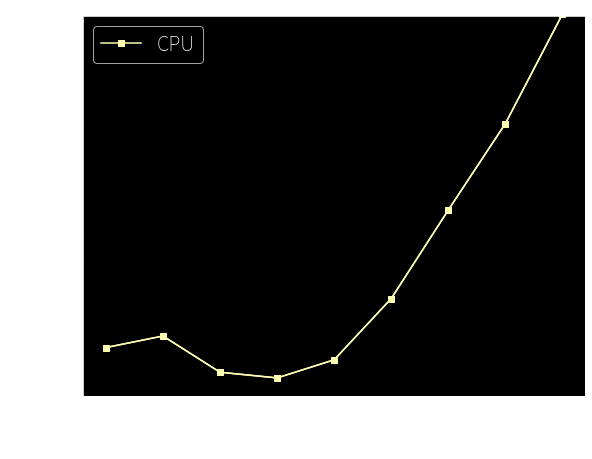

In [13]:
cpu_data = []
gpu_data = []
for n in range(9):
    n = 10**n
    # 创建在CPU上运算的2个矩阵
    with tf.device('/cpu:0'):
        cpu_a = tf.random.normal([1, n])
        cpu_b = tf.random.normal([n, 1])
        print(cpu_a.device, cpu_b.device)
    # 创建使用GPU运算的2个矩阵
#     with tf.device('/gpu:0'):
#         gpu_a = tf.random.normal([1, n])
#         gpu_b = tf.random.normal([n, 1])
#         print(gpu_a.device, gpu_b.device)

    def cpu_run():
        with tf.device('/cpu:0'):
            c = tf.matmul(cpu_a, cpu_b)
        return c

    def gpu_run():
        with tf.device('/gpu:0'):
            c = tf.matmul(gpu_a, gpu_b)
        return c

    # 第一次计算需要热身，避免将初始化阶段时间结算在内
    cpu_time = timeit.timeit(cpu_run, number=10)
#     gpu_time = timeit.timeit(gpu_run, number=10)
#     print('warmup:', cpu_time, gpu_time)
    # 正式计算10次，取平均时间
    cpu_time = timeit.timeit(cpu_run, number=10)
#     gpu_time = timeit.timeit(gpu_run, number=10)
#     print('run time:', cpu_time, gpu_time)
    cpu_data.append(cpu_time/10)
#     gpu_data.append(gpu_time/10)

    del cpu_a, cpu_b # gpu_a, gpu_b

x = [10**i for i in range(9)]
cpu_data = [1000*i for i in cpu_data]
# gpu_data = [1000*i for i in gpu_data]
plt.plot(x, cpu_data, 'C1')
plt.plot(x, cpu_data, color='C1', marker='s', label='CPU')
# plt.plot(x, gpu_data, 'C0')
# plt.plot(x, gpu_data, color='C0', marker='^', label='GPU')


plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.ylim([0, 100])
plt.xlabel('矩阵大小n:(1xn)@(nx1)')
plt.ylabel('运算时间(ms)')
plt.legend()
# plt.savefig('gpu-time.svg')


2. 自动梯度

    在使用 TensorFlow 构建前向计算过程的时候，除了能够获得数值结果，TensorFlow 还
    会自动构建计算图，通过 TensorFlow 提供的自动求导的功能，可以不需要手动推导，即可
    计算输出对网络参数的偏导数.表达式:
    $$y = aw^2 + bw + c$$
    导数:
    $$\frac {dy} {dw} = 2aw +b$$
    当(a, b, c, w) = (1, 2, 3, 4)处导数, 得到导数值为10
    通过 TensorFlow 的方式，我们可以不需要手动推导导数的表达式，直接给出函数的表达式，即可由 TensorFlow 自动求导，代码实现如下

In [14]:
a = tf.constant(1.)
b = tf.constant(2.)
c = tf.constant(3.)
w = tf.constant(4.)

with tf.GradientTape() as tape:  # 梯度环境
    tape.watch([w])  # 将w加入梯度跟踪列表
    # 构建计算过程, 函数表达式
    y = a * w ** 2 + b * w + c
# 自动求导
[dy_dw] = tape.gradient(y, [w])
dy_dw

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

3. 常用神经网络接口

    TensorFlow 除了提供底层的矩阵相乘、相加等数学函数，还内建了常用神经网络运算
    函数、常用网络层、网络训练、模型保存与加载、网络部署等一系列深度学习系统的便捷
    功能。使用 TensorFlow 开发，可以方便地利用这些功能完成常用业务流程，高效稳定